In [1]:
# Import packages
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lars_path
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score
import scipy.stats as stats
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import our data
df = pd.read_csv('tomslee_airbnb_new_york_1438_2017-07-12.csv')

In [3]:
# find column names and data types
df.dtypes

room_id                   int64
survey_id                 int64
host_id                   int64
room_type                object
country                 float64
city                     object
borough                  object
neighborhood             object
reviews                   int64
overall_satisfaction    float64
accommodates              int64
bedrooms                float64
bathrooms               float64
price                   float64
minstay                 float64
name                     object
property_type            object
last_modified            object
latitude                float64
longitude               float64
location                 object
dtype: object

# Investigate Dataset

In [4]:
# Preview Dataset

df.head(5)

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,...,bedrooms,bathrooms,price,minstay,name,property_type,last_modified,latitude,longitude,location
0,7739955,1438,38614070,Shared room,NaN,New York,Queens,Jackson Heights,6,5.0,...,1.0,NaN,85.0,NaN,"Room TO SHARE by DAY,week,month",House,2017-07-15 21:30:31.858764,40.749909,-73.876880,0101000020E61000000EA14ACD1E7852C0F0FCA204FD5F...
1,7383173,1438,32628813,Shared room,NaN,New York,Brooklyn,Cypress Hills,14,4.0,...,1.0,NaN,90.0,NaN,Spacious Room: Close to Manhattan,House,2017-07-15 21:30:30.332828,40.678527,-73.889584,0101000020E6100000DFC2BAF1EE7852C0FC3905F9D956...
2,10250852,1438,35553123,Shared room,NaN,New York,Brooklyn,Sheepshead Bay,3,4.5,...,1.0,NaN,239.0,NaN,COZY COUCH,Apartment,2017-07-15 21:30:23.607950,40.583041,-73.957976,0101000020E61000009696917A4F7D52C0139D6516A14A...
3,2188359,1438,5029659,Shared room,NaN,New York,Manhattan,Hell's Kitchen,35,5.0,...,1.0,NaN,165.0,NaN,1 Bdrm Apt 1 Block from Times Sq.,Apartment,2017-07-15 21:30:21.832749,40.758374,-73.991955,0101000020E6100000A306D3307C7F52C0801134661261...
4,19661354,1438,70038324,Shared room,NaN,New York,Manhattan,Upper East Side,0,0.0,...,1.0,NaN,159.0,NaN,NYC Upper East / Midtown East Luxury 1BR,Apartment,2017-07-15 21:30:19.986579,40.761960,-73.959733,0101000020E610000016F9F5436C7D52C01A6EC0E78761...


In [5]:
# Descriptive Statistics of the data
df.describe()

,room_id,survey_id,host_id,country,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,4.124500e+04,41245.0,4.124500e+04,0.0,41245.000000,41245.000000,41245.000000,41245.000000,0.0,41245.000000,0.0,41245.000000,41245.000000
mean,1.097598e+07,1438.0,3.477635e+07,NaN,17.463571,2.735774,2.851982,1.162395,NaN,136.103528,NaN,40.731183,-73.954717
std,6.098062e+06,0.0,3.755800e+07,NaN,31.917262,2.336536,1.865672,0.763021,NaN,166.615958,NaN,0.054861,0.042493
min,2.515000e+03,1438.0,7.200000e+01,NaN,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,NaN,40.508684,-74.239859
25%,5.806817e+06,1438.0,5.334697e+06,NaN,1.000000,0.000000,2.000000,1.000000,NaN,65.000000,NaN,40.691208,-73.983521
50%,1.179878e+07,1438.0,2.029277e+07,NaN,4.000000,4.500000,2.000000,1.000000,NaN,100.000000,NaN,40.725062,-73.956776
75%,1.633739e+07,1438.0,5.065631e+07,NaN,19.000000,5.000000,4.000000,1.000000,NaN,160.000000,NaN,40.765689,-73.939254
max,1.987405e+07,1438.0,1.405179e+08,NaN,454.000000,5.000000,16.000000,50.000000,NaN,9999.000000,NaN,40.908039,-73.702257


In [6]:
# Find number of data points for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41245 entries, 0 to 41244
Data columns (total 21 columns):
room_id                 41245 non-null int64
survey_id               41245 non-null int64
host_id                 41245 non-null int64
room_type               41245 non-null object
country                 0 non-null float64
city                    41245 non-null object
borough                 41245 non-null object
neighborhood            41245 non-null object
reviews                 41245 non-null int64
overall_satisfaction    41245 non-null float64
accommodates            41245 non-null int64
bedrooms                41245 non-null float64
bathrooms               0 non-null float64
price                   41245 non-null float64
minstay                 0 non-null float64
name                    41221 non-null object
property_type           41245 non-null object
last_modified           41245 non-null object
latitude                41245 non-null float64
longitude               412

# Data Wrangling


In [7]:
#Find null values
df.isnull().sum()

room_id                     0
survey_id                   0
host_id                     0
room_type                   0
country                 41245
city                        0
borough                     0
neighborhood                0
reviews                     0
overall_satisfaction        0
accommodates                0
bedrooms                    0
bathrooms               41245
price                       0
minstay                 41245
name                       24
property_type               0
last_modified               0
latitude                    0
longitude                   0
location                    0
dtype: int64

In [8]:
# Delete unnecessary data
del df['country']

In [9]:
del df['bathrooms']

In [10]:
del df['minstay']

In [11]:
del df['survey_id']

In [12]:
del df['location']

In [13]:
del df['name']

In [14]:
del df['last_modified']

In [15]:
# Delete data where there are no reviews as their overall score doesnt contribute 
df = df[df['reviews'] != 0]

In [16]:
# Remove data with 0 price information
df = df[df['price'] > 0]

In [17]:
df.dropna(inplace= True)

In [18]:
df.shape

(31384, 14)

In [19]:
df.price.describe()

count    31384.00000
mean       131.04190
std        142.48892
min         10.00000
25%         65.00000
50%        100.00000
75%        159.00000
max       9999.00000
Name: price, dtype: float64

In [20]:
df.property_type.value_counts()

Apartment             26482
House                  2904
Loft                    661
Townhouse               544
Condominium             340
Other                   135
Bed & Breakfast         124
Guesthouse               43
Timeshare                24
Hostel                   22
Guest suite              19
Villa                    17
Bungalow                 16
Dorm                     15
Boutique hotel           12
Boat                      4
Earth House               3
Castle                    3
Vacation home             3
Cabin                     3
Serviced apartment        2
In-law                    2
Camper/RV                 2
Chalet                    2
Cave                      1
Casa particular           1
Name: property_type, dtype: int64

In [21]:
# That will be a hassle for dummy values, lets aggregate the smaller values into 'Other'
series =pd.value_counts(df.property_type)
mask = (series/series.sum() *100).lt(1)
df['property_type'] = np.where(df['property_type'].isin(series[mask].index), 'Other', df['property_type'])

In [22]:
df.property_type.value_counts()

Apartment      26482
House           2904
Loft             661
Townhouse        544
Other            453
Condominium      340
Name: property_type, dtype: int64

In [23]:
df.borough.value_counts()

Manhattan        14649
Brooklyn         12808
Queens            3187
Bronx              532
Staten Island      208
Name: borough, dtype: int64

In [24]:
df.room_type.value_counts()

Entire home/apt    16269
Private room       14336
Shared room          779
Name: room_type, dtype: int64

In [25]:
(1080/41221)*100


2.6200237742898036

In [26]:
# As shared rooms only represent 2% of our dataset, we're going to drop those values
df = df[df['room_type'] != 'Shared room']

In [27]:
# Find top 10 Neighborhoods
top10_nb = df.neighborhood.value_counts().head(10)
print(top10_nb)

Williamsburg          2585
Bedford-Stuyvesant    2094
Harlem                1940
Bushwick              1392
Upper West Side       1385
East Village          1296
Hell's Kitchen        1234
Upper East Side       1173
Crown Heights         1011
Chelsea                826
Name: neighborhood, dtype: int64


In [28]:
top10nb_df = df[df['neighborhood'].isin(['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side',
                                        'East Village', 'Hell\'s Kitchen', 'Upper East Side', 'Crown Heights', 'Chelsea'])]
top10nb_df


,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,property_type,latitude,longitude
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,95.0,Apartment,40.693212,-73.944198
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,90.0,Apartment,40.685574,-73.948643
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,3497.0,Apartment,40.724882,-73.984570
1017,893413,4751930,Entire home/apt,New York,Manhattan,East Village,8,5.0,8,3.0,1550.0,Townhouse,40.726676,-73.981791
1027,8739642,44179601,Entire home/apt,New York,Manhattan,Chelsea,4,5.0,12,4.0,900.0,Apartment,40.744556,-73.992671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41226,15990572,103841276,Private room,New York,Brooklyn,Bushwick,31,4.5,2,1.0,35.0,Townhouse,40.699944,-73.932240
41227,2232697,1726966,Private room,New York,Brooklyn,Crown Heights,72,4.5,1,1.0,34.0,Apartment,40.671672,-73.924342
41228,16546347,106838618,Private room,New York,Brooklyn,Bedford-Stuyvesant,51,4.5,1,1.0,28.0,Apartment,40.680030,-73.910428
41230,7717598,40532977,Private room,New York,Brooklyn,Bedford-Stuyvesant,55,4.5,2,1.0,30.0,Apartment,40.679824,-73.913473


In [29]:
top10nb_df.corr()['price'].sort_values()

longitude              -0.296998
room_id                -0.065932
host_id                -0.029458
reviews                -0.024628
overall_satisfaction    0.034026
latitude                0.113349
bedrooms                0.409443
accommodates            0.540479
price                   1.000000
Name: price, dtype: float64

In [30]:
top10nb_df.overall_satisfaction.value_counts()

5.0    5761
4.5    4883
0.0    3430
4.0     725
3.5     111
3.0      18
2.5       7
1.0       1
Name: overall_satisfaction, dtype: int64

In [31]:
df.overall_satisfaction.describe()

count    30605.000000
mean         3.592844
std          2.023752
min          0.000000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: overall_satisfaction, dtype: float64

In [32]:
df.corr()['price'].sort_values()

longitude              -0.197157
room_id                -0.063815
host_id                -0.039098
reviews                -0.023842
overall_satisfaction    0.010995
latitude                0.030989
bedrooms                0.359862
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [33]:
# Place dummy data for for property type
dummy = pd.get_dummies(df['property_type'])
dummy.head()

,Apartment,Condominium,House,Loft,Other,Townhouse
1008,1,0,0,0,0,0
1009,1,0,0,0,0,0
1011,1,0,0,0,0,0
1013,1,0,0,0,0,0
1015,0,0,1,0,0,0


In [34]:
df = pd.concat([df, dummy], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,property_type,latitude,longitude,Apartment,Condominium,House,Loft,Other,Townhouse
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,113.0,Apartment,40.659736,-73.898677,1,0,0,0,0,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,95.0,Apartment,40.693212,-73.944198,1,0,0,0,0,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,90.0,Apartment,40.685574,-73.948643,1,0,0,0,0,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,3497.0,Apartment,40.724882,-73.984570,1,0,0,0,0,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,8000.0,House,40.691371,-73.967228,0,0,1,0,0,0


In [35]:
dummy3 = pd.get_dummies(df['borough'])
dummy3.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1008,0,1,0,0,0
1009,0,1,0,0,0
1011,0,1,0,0,0
1013,0,0,1,0,0
1015,0,1,0,0,0


In [36]:
df = pd.concat([df, dummy3], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,...,Condominium,House,Loft,Other,Townhouse,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,...,0,0,0,0,0,0,1,0,0,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,...,0,0,0,0,0,0,1,0,0,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,...,0,0,0,0,0,0,1,0,0,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,...,0,0,0,0,0,0,0,1,0,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,...,0,1,0,0,0,0,1,0,0,0


In [37]:
df.corr()['price'].sort_values()

longitude              -0.197157
Brooklyn               -0.112679
Queens                 -0.102196
room_id                -0.063815
Bronx                  -0.060032
Apartment              -0.041056
host_id                -0.039098
Staten Island          -0.025549
reviews                -0.023842
House                  -0.016561
Other                  -0.003149
overall_satisfaction    0.010995
latitude                0.030989
Townhouse               0.032188
Loft                    0.063340
Condominium             0.065133
Manhattan               0.192303
bedrooms                0.359862
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [38]:
dummy4 = pd.get_dummies(df['room_type'])
dummy4.head()

,Entire home/apt,Private room
1008,1,0
1009,1,0
1011,1,0
1013,1,0
1015,1,0


In [39]:
df = pd.concat([df, dummy4], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,...,Loft,Other,Townhouse,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,...,0,0,0,0,1,0,0,0,1,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,...,0,0,0,0,1,0,0,0,1,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,...,0,0,0,0,1,0,0,0,1,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,...,0,0,0,0,0,1,0,0,1,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,...,0,0,0,0,1,0,0,0,1,0


In [40]:
df.corr()['price'].sort_values()

Private room           -0.376005
longitude              -0.197157
Brooklyn               -0.112679
Queens                 -0.102196
room_id                -0.063815
Bronx                  -0.060032
Apartment              -0.041056
host_id                -0.039098
Staten Island          -0.025549
reviews                -0.023842
House                  -0.016561
Other                  -0.003149
overall_satisfaction    0.010995
latitude                0.030989
Townhouse               0.032188
Loft                    0.063340
Condominium             0.065133
Manhattan               0.192303
bedrooms                0.359862
Entire home/apt         0.376005
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [41]:
# Add a feature for logarithmic price
df['log_price'] = np.log(df['price'])

#Create variables for log_price mean and STD
lgpm = df.log_price.mean()
lgps = df.log_price.std()

In [59]:
model_df = df[df['log_price'] >= lgpm - (2*lgps)]
model_df = df[df['log_price'] <= (2*lgps)+lgpm]

# Data Visualization

In [43]:
#sns.pairplot(df, diag_kind="kde", height=2.5)

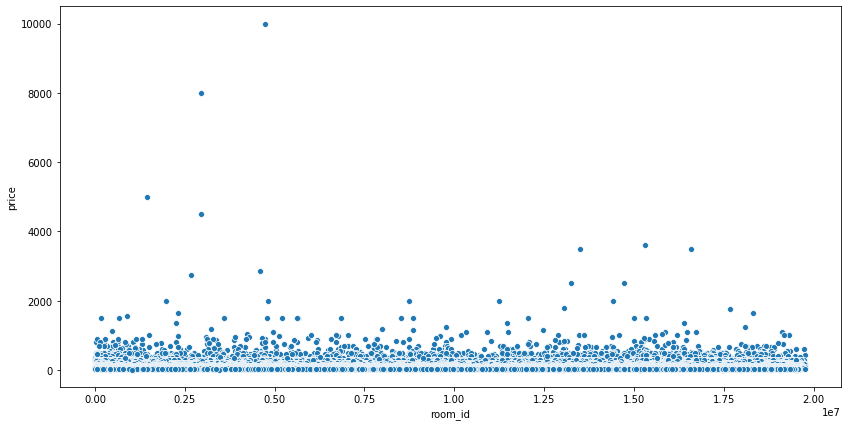

In [44]:
plt.figure(figsize = (14,7))
sns.scatterplot(data = df, x = df['room_id'], y = df['price'])

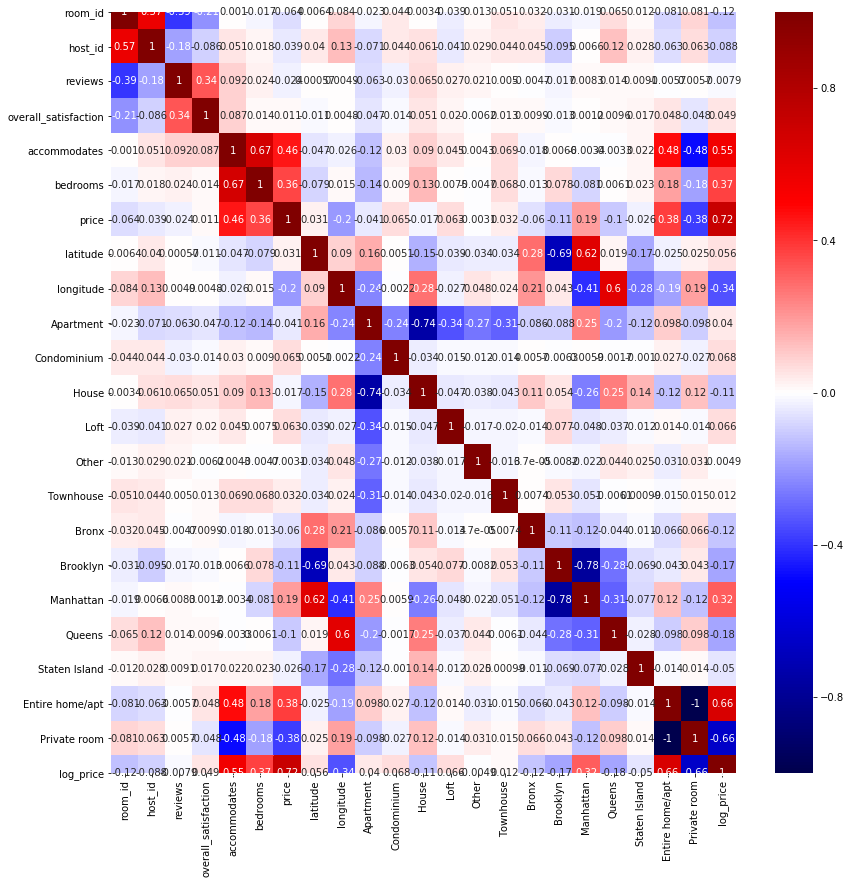

In [45]:
plt.figure(figsize = (14,14))
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

Skewness: 0.434114
Kurtosis: 0.718808


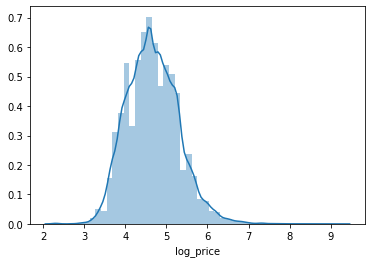

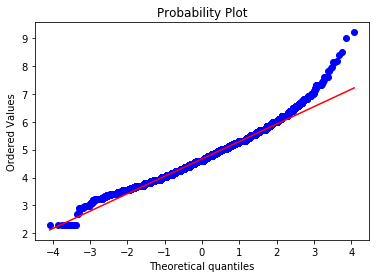

In [46]:
sns.distplot(df['log_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(df['log_price'], plot=plt)
print("Skewness: %f" % df['log_price'].skew())
print("Kurtosis: %f" % df['log_price'].kurt())

Skewness: -0.034736
Kurtosis: -0.492592


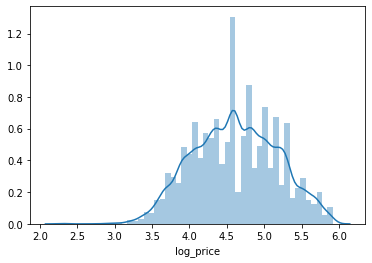

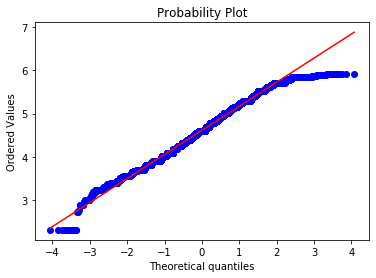

In [60]:
sns.distplot(model_df['log_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(model_df['log_price'], plot=plt)
print("Skewness: %f" % model_df['log_price'].skew())
print("Kurtosis: %f" % model_df['log_price'].kurt())

Text(0.5, 1.0, 'Density and Distribution of prices for each neighborhood')

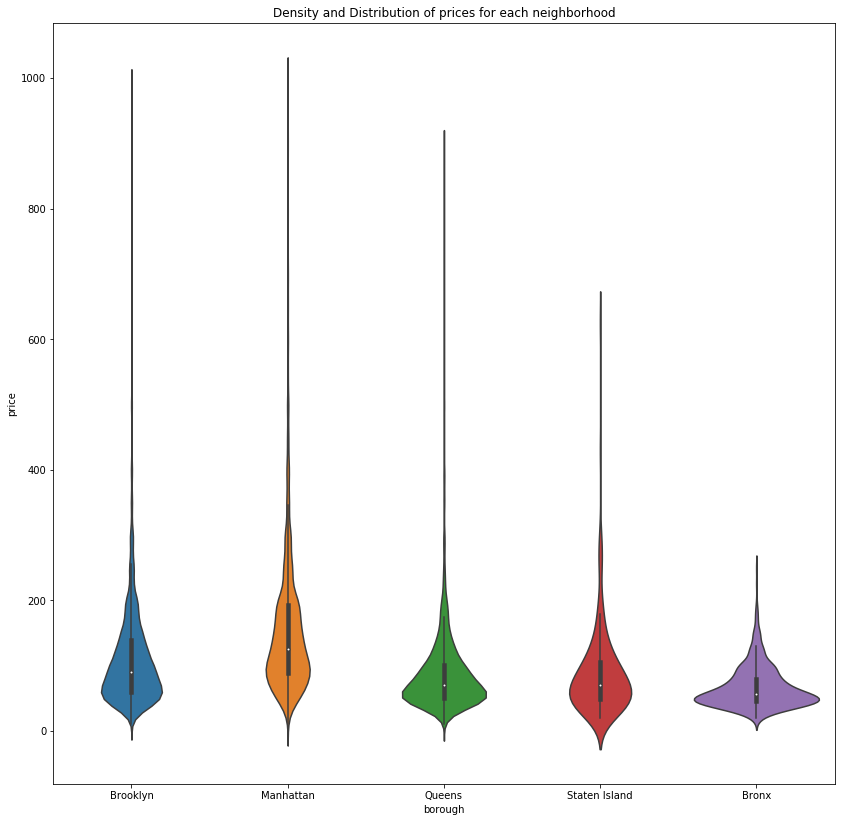

In [47]:
sdf = df[df.price < 1000]

plt.figure(figsize = (14,14))
nb_dens_plot = sns.violinplot(data=sdf, x='borough', y='price')
nb_dens_plot.set_title('Density and Distribution of prices for each neighborhood')


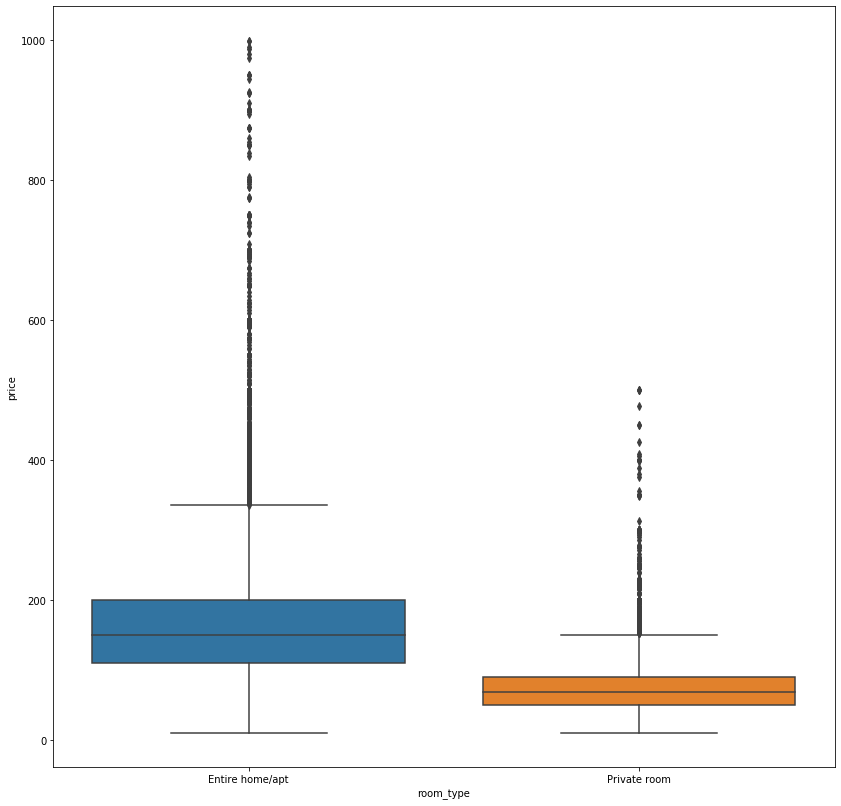

In [48]:
plt.figure(figsize = (14,14))
sns.boxplot(data = sdf, x = 'room_type', y = 'price')

In [57]:
df['Map'] = df['price'].apply(lambda x: 'Luxury' if x > 1000
                                                    else ('Premium' if x >= 500 and x < 1000
                                                          else('Affordable' if x >= 200 and x < 500
                                                               else('Economic'))))
                                                                    

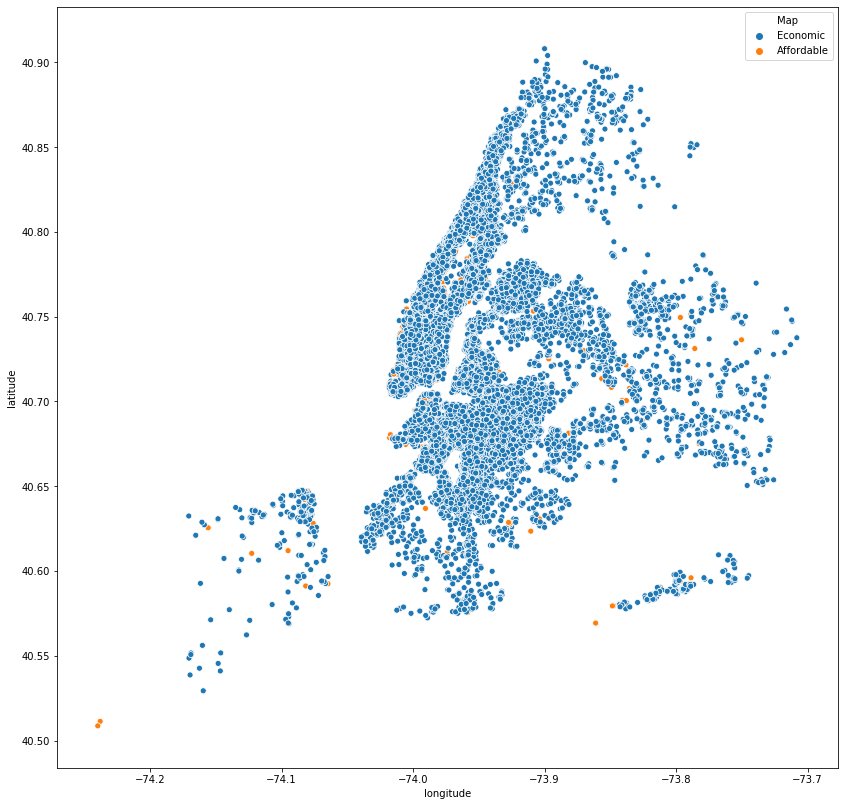

In [61]:
plt.figure(figsize = (14,14))
sns.scatterplot(df.longitude, df.latitude, hue='Map', data= model_df)

<Figure size 1008x1008 with 0 Axes>

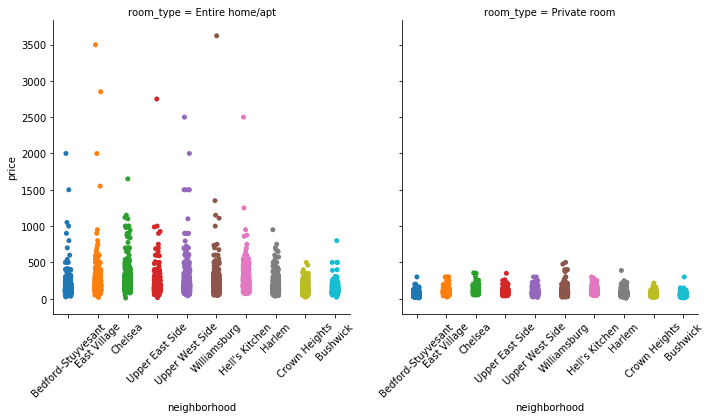

In [51]:
plt.figure(figsize = (14,14))
nbplot = sns.catplot(x='neighborhood', y = 'price', col= 'room_type', data =top10nb_df)
nbplot.set_xticklabels(rotation=45)

# Hypothesis Testing

In [52]:
# NH
# AH
# ANOVA 5 boros
# Multiple comparison test
# boros vs each other
# p values for each one

In [53]:
# ins

# Model Development

In [54]:
X = model_df[['accommodates']]
Y = model_df['price']
lm = LinearRegression()
lm
lm.fit(X,Y)
lm.score(X, Y)

0.25826316274546457

In [ ]:
model_df.

In [55]:
Z = model_df[["Entire home/apt", "bedrooms","Manhattan" ,"bedrooms" ,"Condominium" ,"Loft" ,"Townhouse","latitude","accommodates","overall_satisfaction"]]     
lm.fit(Z, df['log_price'])
lm.predict(Z)

ValueError: Found input variables with inconsistent numbers of samples: [29631, 30605]

In [ ]:
lm.score(Z, df['price'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y, random_state=26)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
lm.fit(X_train, Y_train)

In [ ]:
predictions = lm.predict(X_test)
predictions

In [ ]:
plt.figure(figsize = (14,14))
plt.scatter(Y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [ ]:
# log scale y variable
# Find out price data
# remove the outliers
# check for amount of zeros
